In [3]:
from plotnine import *
import pandas as pd
import numpy as np

In [4]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"
time = "2024-04-19_09:39"
time = "2024-05-19_16:34"
time = "2024-05-19_16:58"
time = "2024-05-19_17:38"
time = "2024-05-19_18:55"
time = "2024-05-20_04:15"
time = "2024-05-20_10:30"
time = "2024-05-29_13:27"
time = "2024-06-10_12:52" # EUR_USD_M15
time = "2024-06-10_19:47" # GBP_USD_M15
time = "2024-06-10_22:59" # USD_JPY_M15
time = "2024-06-11_04:01" # USD_CHF_M15
time = "2024-06-11_04:14" # USD_CAD_M15
time = "2024-06-11_11:42" # AUD_USD_M15
time = "2024-06-11_23:43" # AUD_JPY_M15
time = "2024-06-11_23:48" # AUD_CAD_M15
time = "2024-06-12_08:44" # EUR_JPY_M15
time = "2024-06-12_08:48" # GBP_CHF_M15
time = "2024-06-12_08:52" # GBP_JPY_M15


time = "2024-07-15_11:09" # GBP_USD_M15


df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["algorithm"] == "kmeans"]

df = df[(df["test_sharpe_ratio"] >= 0.15) | (df["test_inverse_sharpe_ratio"] >= 0.15)]

# df = df[(df["algorithm"] == 'gaussian_mixture')]
# df = df[(df["max_k_labels"] == 1)]
# df = df[(df["random_state"] == 200)]

df

,window,train_total_annualized_return,train_total_actual_return,train_total_trades,test_total_annualized_return,test_total_actual_return,test_total_trades,train_cumulative_annualized_return,train_cumulative_actual_return,train_sharpe_ratio,test_cumulative_annualized_return,test_cumulative_actual_return,test_sharpe_ratio,test_inverse_sharpe_ratio,max_cluster_labels,num_clusters,clustering_algorithm,train_period,test_period,random_seed
6810,0,1.36,136.0,493,0.02,2.0,76,1.36,136.0,3.518490,0.02,2.0,0.152857,-0.206781,5,80,gaussian_mixture,4800,960,20
6811,1,1.58,158.0,358,0.24,24.0,48,2.94,294.0,3.518490,0.26,26.0,0.152857,-0.206781,5,80,gaussian_mixture,4800,960,20
6812,2,2.16,216.0,375,0.69,69.0,77,5.10,510.0,3.518490,0.95,95.0,0.152857,-0.206781,5,80,gaussian_mixture,4800,960,20
6813,3,2.48,248.0,625,-0.16,-16.0,74,7.58,758.0,3.518490,0.79,79.0,0.152857,-0.206781,5,80,gaussian_mixture,4800,960,20
6814,4,2.07,207.0,374,0.51,51.0,77,9.65,965.0,3.518490,1.30,130.0,0.152857,-0.206781,5,80,gaussian_mixture,4800,960,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538020,118,2.63,263.0,592,-0.15,-15.0,85,295.73,29573.0,3.923022,7.82,782.0,0.168928,-0.236389,5,80,kmeans,8640,960,200
538021,119,1.92,192.0,645,-0.32,-32.0,87,297.65,29765.0,3.923022,7.50,750.0,0.168928,-0.236389,5,80,kmeans,8640,960,200
538022,120,1.80,180.0,665,-0.08,-8.0,63,299.45,29945.0,3.923022,7.42,742.0,0.168928,-0.236389,5,80,kmeans,8640,960,200
538023,121,1.43,143.0,641,0.17,17.0,81,300.88,30088.0,3.923022,7.59,759.0,0.168928,-0.236389,5,80,kmeans,8640,960,200


/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


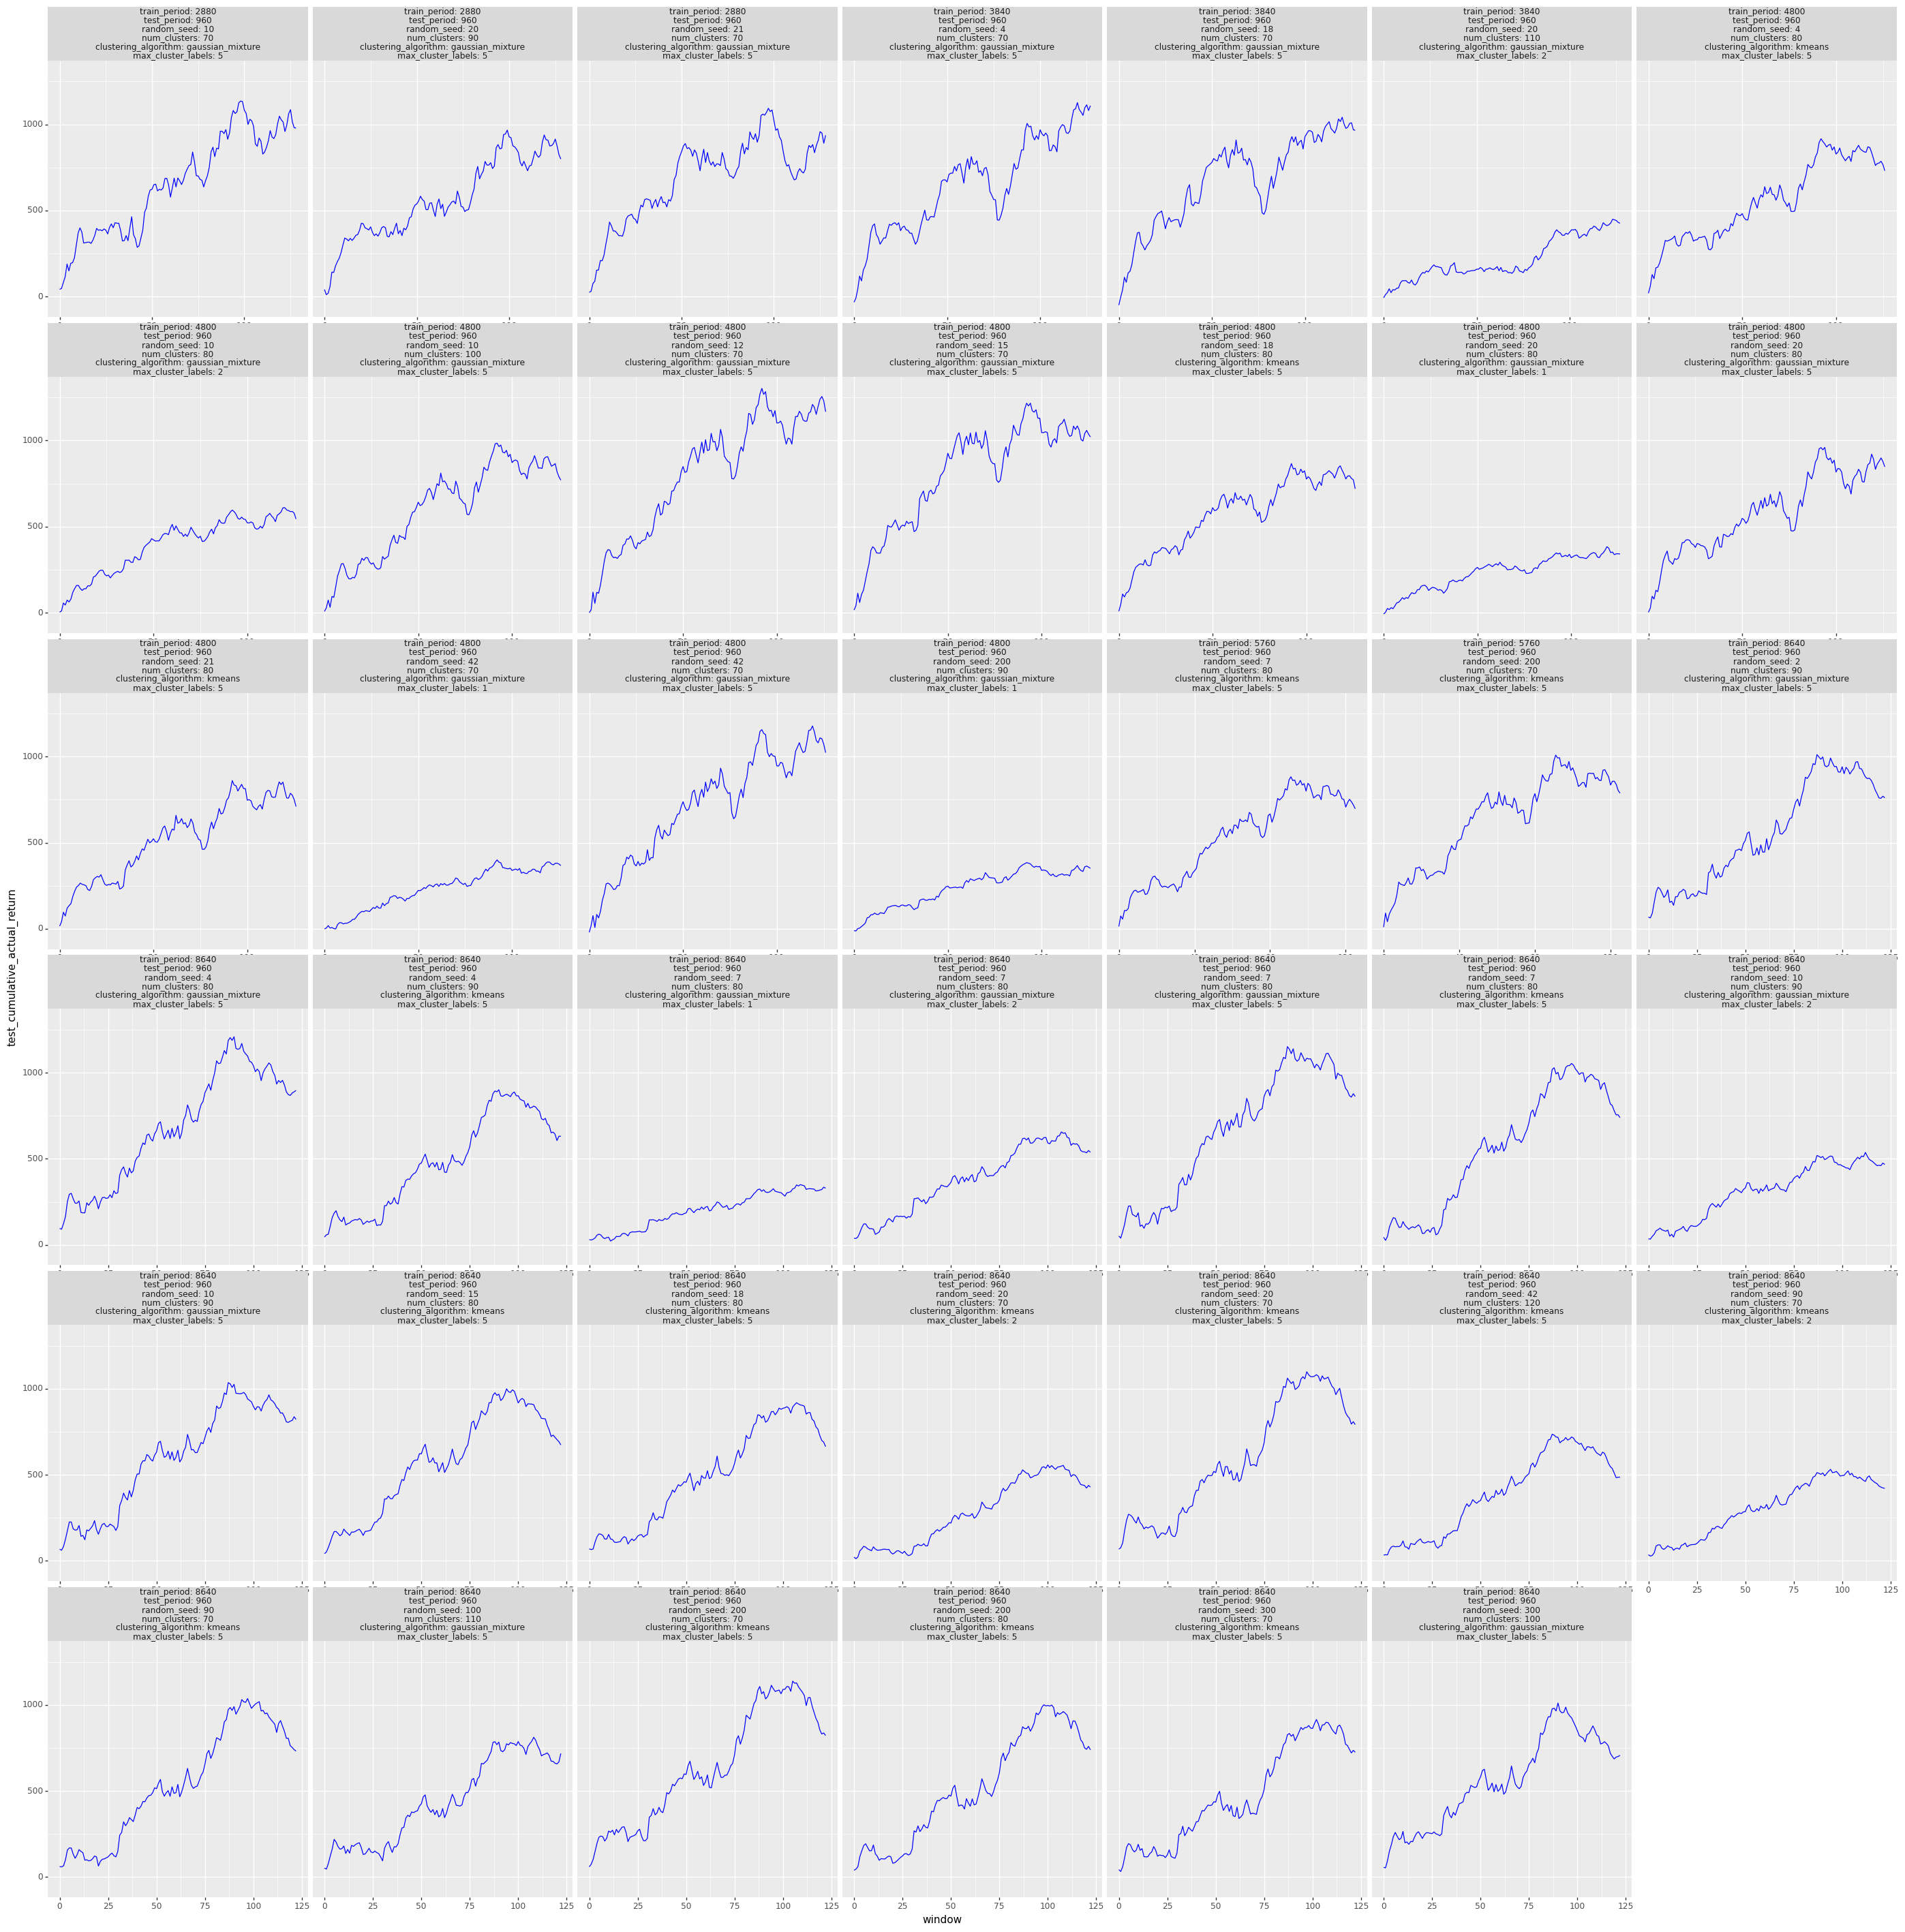

In [5]:
p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_period + random_seed", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels", scales="free_x", labeller="label_both")
p = p + theme(figure_size=(35, 35))
# p = p + theme(figure_size=(15, 15))
print(p)

In [ ]:

time = "2024-03-14_19:00"
df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/kmeans/results/{time}_results.csv")

p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumsum_annualized_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_cumsum_annualized_return"), color="red")
p = p + facet_wrap("~train_size + test_size + random_state", scales="free_x", labeller="label_both")
p = p + theme(axis_text_x=element_text(angle=90), figure_size=(30, 30))
print(p)